In [1]:
import tensorflow as tf
import numpy as np
import awkward as ak

2022-06-22 16:06:44.883372: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.1-8d929/x86_64-centos7-gcc8-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.1-f3599/x86_64-centos7-gcc8-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow/contrib/tensor_forest:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow/python/framework:/cvmfs/sft.cern.ch/lcg/releases/java/8u222-884d8/x86_64-centos7-gcc8-opt/jre/lib/amd64:/cvmfs/sft.

In [2]:
import tensorflow as tf
import json, os
import numpy as np

# Tested with TensorFlow 2.1.0
print('version={}, CUDA={}, GPU={}'.format(
    tf.__version__, tf.test.is_built_with_cuda(),
    len(tf.config.list_physical_devices('GPU')) > 0))
      
if len(tf.config.list_physical_devices('GPU')) > 0:
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
    strategy = tf.distribute.OneDeviceStrategy("gpu:0")
else:
    strategy = tf.distribute.OneDeviceStrategy("cpu:0")



version=2.5.0, CUDA=True, GPU=False


2022-06-22 16:06:53.210710: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.1-8d929/x86_64-centos7-gcc8-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.1-f3599/x86_64-centos7-gcc8-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow/contrib/tensor_forest:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow/python/framework:/cvmfs/sft.cern.ch/lcg/releases/java/8u222-884d8/x86_64-centos7-gcc8-opt/jre/lib/amd64:/cvmfs/sft.cern.ch/lc

In [3]:
#########################3
# Masking utils

def create_padding_masks(rechits):
    #mask_rechits = tf.cast(tf.reduce_sum(rechits,-1) != 0, tf.float32)
    mask_cls = tf.cast(tf.reduce_sum(rechits,[-1]) != 0, tf.float32)
    return mask_cls

###########################

def point_wise_feed_forward_network(d_model, dff, name="fff"):
      return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ],name=name)

    
def get_dense(spec, act, last_act, dropout=0., L2=False, L1=False, name="dense"):
    layers = [] 
    for i, d in enumerate(spec[:-1]):
        if not L1 and not L2:
            layers.append(tf.keras.layers.Dense(d, activation=act, name=name+"_{}".format(i)))
        if not L1 and L2:
            layers.append(tf.keras.layers.Dense(d, activation=act, kernel_regularizer=tf.keras.regularizers.L2(0.001), name=name+"_{}".format(i)))
        if not L2 and L1:
            layers.append(tf.keras.layers.Dense(d, activation=act, kernel_regularizer=tf.keras.regularizers.L1(0.001),name=name+"_{}".format(i)))
        if L1 and L2:
            layers.append(tf.keras.layers.Dense(d, activation=act, kernel_regularizer=tf.keras.regularizers.L1L2(0.001,0.001),name=name+"_{}".format(i)))
        if dropout > 0.:
            layers.append(tf.keras.layers.Dropout(dropout))
    layers.append(tf.keras.layers.Dense(spec[-1], activation=last_act, name=name+"_{}".format(i+1)))
    return tf.keras.Sequential(layers, name=name)

def get_conv1d(spec, act, last_act, dropout=0., L2=False, L1=False, name="dense"):
    layers = [] 
    for i, d in enumerate(spec[:-1]):
        if not L1 and not L2:
            layers.append(tf.keras.layers.Conv1D(filters=d,kernel_size=1, activation=act, name=name+"_{}".format(i)))
        if not L1 and L2:
            layers.append(tf.keras.layers.Conv1D(filters=d,kernel_size=1, activation=act, kernel_regularizer=tf.keras.regularizers.L2(0.001), name=name+"_{}".format(i)))
        if not L2 and L1:
            layers.append(tf.keras.layers.Conv1D(filters=d,kernel_size=1, activation=act, kernel_regularizer=tf.keras.regularizers.L1(0.001),name=name+"_{}".format(i)))
        if L1 and L2:
            layers.append(tf.keras.layers.Conv1D(filters=d,kernel_size=1, activation=act, kernel_regularizer=tf.keras.regularizers.L1L2(0.001,0.001),name=name+"_{}".format(i)))
        if dropout > 0.:
            layers.append(tf.keras.layers.Dropout(dropout))
    layers.append(tf.keras.layers.Conv1D(filters=spec[-1], kernel_size=1, activation=last_act, name=name+"_{}".format(i+1)))
    return tf.keras.Sequential(layers, name=name)



In [4]:
############################
# From https://www.tensorflow.org/tutorials/text/transformer#multi-head_attention
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.
    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    Returns:
    output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        # the mask signals the elements to keep so we have to invert it
        scaled_attention_logits += ( (1 - mask) * -1e9)  

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)
    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)
    return output, attention_weights


########################################

class SelfAttention(tf.keras.layers.Layer):
    '''
    Self attention layer only computing the SA computation
    Input : [Nbatch, Nclusters, input_dim]
    Output:  [Nbatch, Nclusters, output_dim]
    '''    
    def __init__(self, input_dim, output_dim, *args, **kwargs):
        self.activation = kwargs.pop("activation", "relu")
        self.input_dim = input_dim
        self.output_dim = output_dim
        name = kwargs.pop("name", None)

        super(SelfAttention, self).__init__(name=name)

        # Self-attention matrices
        self.Q = self.add_weight(shape=(self.input_dim, self.output_dim), name="Q_sa_"+name, initializer="random_normal")
        self.K = self.add_weight(shape=(self.input_dim, self.output_dim), name="K_sa_"+name, initializer="random_normal")
        self.V = self.add_weight(shape=(self.input_dim, self.output_dim), name="V_sa_"+name, initializer="random_normal")


    def get_config():
        return {
            "input_dim" : self.input_dim,
            "output_dim": self.output_dim,
            "name": self.name
        }
        
    def call(self, x, mask, training):
        # x has structure  [Nbatch, Nclusters, Nfeatures]
        q = tf.matmul(x,self.Q)
        k = tf.matmul(x,self.K)
        v = tf.matmul(x,self.V)
        # mask the padded clusters in the attention distance
        mask_for_attention = mask[:,tf.newaxis,:]
        # Mask for output
        mask_for_nodes = mask[:,:,tf.newaxis]
        # Get self-attention output and attention weights
        sa_output, attention_weights = scaled_dot_product_attention(q, k, v, mask_for_attention)
        # Dropout
        sa_output = sa_output * mask_for_nodes
        
        return sa_output, attention_weights

####################################################

class SelfAttentionBlock(tf.keras.layers.Layer):
    '''
    Generic self attention layer that can reduce or not the output feature vectors.
    Input : [Nbatch, Nclusters, input_dim]
    Output:  
            - reduce=none  [Nbatch, Nclusters, output_dim]  
            - reduce=sum or mean   [Nbatch, output_dim]  
    '''    
    def __init__(self, input_dim, output_dim, reduce=None, *args, **kwargs):
        self.activation = kwargs.pop("activation", "relu")
        self.dropout = kwargs.get("dropout", 0.)
        self.l2_reg = kwargs.get("l2_reg", False)
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.reduce = reduce # it can be None, sum, mean, max
        name = kwargs.pop("name", None)

        super(SelfAttentionBlock, self).__init__(name=name)
        
        # Self-attention matrices
        self.Q = self.add_weight(shape=(self.input_dim, self.output_dim), name="Q_sa_"+name, initializer="random_normal")
        self.K = self.add_weight(shape=(self.input_dim, self.output_dim), name="K_sa_"+name, initializer="random_normal")
        self.V = self.add_weight(shape=(self.input_dim, self.output_dim), name="V_sa_"+name, initializer="random_normal")
        self.inputW = self.add_weight(shape=(self.input_dim, self.output_dim), name="input_sa_"+name, initializer="random_normal")

        # Feed-forward output (1 hidden layer)
        self.dense_out = get_conv1d([self.output_dim, self.output_dim], self.activation, last_act=self.activation,
                                    L2=self.l2_reg, dropout=self.dropout, name="output_sa_"+name)
        # Layer normalizations
        self.norm1 = tf.keras.layers.LayerNormalization(name="SA_lnorm1_"+name, epsilon=1e-3, axis=-1)
        self.norm2 = tf.keras.layers.LayerNormalization(name="SA_lnorm2_"+name, epsilon=1e-3, axis=-1)
        # Dropouts
        self.drop1 = tf.keras.layers.Dropout(self.dropout)
        self.drop2 = tf.keras.layers.Dropout(self.dropout)

    def get_config():
        return {
            "input_dim" : self.input_dim,
            "output_dim": self.output_dim,
            "l2_reg": self.l2_reg,
            "dropout": self.dropout,
            "activation": self.activation,
            "reduce": self.reduce,
            "name": self.name
        }
        
    def call(self, x, mask, training):
        # x has structure  [Nbatch, Nclusters, Nfeatures]
        q = tf.matmul(x,self.Q)
        k = tf.matmul(x,self.K)
        v = tf.matmul(x,self.V)
        # Apply the dense_input to x to get transformed dimension
        transf_input = tf.matmul(x,self.inputW)
        # mask the padded clusters in the attention distance
        mask_for_attention = mask[:,tf.newaxis,:]
        # Mask for output
        mask_for_nodes = mask[:,:,tf.newaxis]
        # Get self-attention output and attention weights
        sa_output, attention_weights = scaled_dot_product_attention(q, k, v, mask_for_attention)
        # Dropout
        sa_output = self.drop1(sa_output, training=training) 
        # Add + layer norm  + mask
        output_sa = self.norm1(transf_input + sa_output) * mask_for_nodes
        # Apply dense
        output_dense = self.dense_out(output_sa, training=training) 
        # Dropout
        output_dense = self.drop2(output_dense, training=training)
        # Add and layer norm
        output_block = self.norm2(output_dense + output_sa) * mask_for_nodes

        # Now the aggregation 
        if self.reduce == "sum":
            return  tf.reduce_sum(output_block, -2), attention_weights
        if self.reduce == "mean":
            N_nodes = tf.reduce_sum(mask,-1)[:,tf.newaxis]
            return tf.math.divide_no_nan( tf.reduce_sum(output_block, -2), N_nodes), attention_weights
        if self.reduce == "max":
            return tf.reduce_max(output_block, axis=-2), attention_weights
        else:
            #just return all the nodes
            return output_block, attention_weights

######################################################################
######################################################################

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, **kwargs):
        self.num_heads = num_heads
        self.d_model = d_model
        name = kwargs.pop("name", None)
        super(MultiHeadAttention, self).__init__(name=name)

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.Wq = tf.keras.layers.Conv1D(filters=self.d_model,kernel_size=1, use_bias=False)
        self.Wk = tf.keras.layers.Conv1D(filters=self.d_model,kernel_size=1, use_bias=False)
        self.Wv = tf.keras.layers.Conv1D(filters=self.d_model,kernel_size=1, use_bias=False)
        self.dense = tf.keras.layers.Conv1D(filters=self.d_model,kernel_size=1, use_bias=False)

    def get_config():
            return {
                "num_heads" : self.num_heads,
                "d_model": self.d_model,
                "name": self.name
            }

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        mask_att = mask[:,tf.newaxis,tf.newaxis,:]

        q = self.Wq(q)  # (batch_size, seq_len, d_model)
        k = self.Wk(k)  # (batch_size, seq_len, d_model)
        v = self.Wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask_att)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        # the output is not masked
        output = self.dense(concat_attention) # (batch_size, seq_len_q, d_model)

        return output, attention_weights


#######################################################################################

class MultiSelfAttentionBlock(tf.keras.layers.Layer):
    def __init__(self, output_dim, num_heads, ff_dim,reduce=None, **kwargs):
        name = kwargs.pop("name", None)
        super(MultiSelfAttentionBlock, self).__init__(name=name)
        self.output_dim = output_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.reduce = reduce # it can be None, sum, mean, max
        self.activation = kwargs.pop("activation", "relu")
        self.dropout = kwargs.get("dropout", 0.)
        self.l2_reg = kwargs.get("l2_reg", False)

        self.inputW = tf.keras.layers.Conv1D(filters=self.output_dim, kernel_size=1, use_bias=False)
        self.mha = MultiHeadAttention(self.output_dim, self.num_heads,name=self.name+"_msa", )
        self.ffn = get_conv1d([self.ff_dim, self.output_dim], self.activation, last_act="linear",
                                        L2=self.l2_reg, dropout=self.dropout, name=self.name+"_ff")

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(self.dropout)
        self.dropout2 = tf.keras.layers.Dropout(self.dropout)

    def get_config():
        return {
            "output_dim" : self.output_dim,
            "ff_dim" : self.ff_dim,
            "num_heads" : self.num_heads,
            "dropout" : self.dropout,
            "name": self.name,
            "reduce": self.reduce
        }
    
    def call(self, x, mask, training):
        mask_out = mask[:,:,tf.newaxis]
        #projecting the input on the MSA dim
        msa_input = self.inputW(x)
        attn_output, attn_weights = self.mha(msa_input,msa_input,msa_input, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(msa_input + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        output_block = self.layernorm2(out1 + ffn_output) * mask_out  # (batch_size, input_seq_len, d_model)

        # Now the aggregation 
        if self.reduce == "sum":
            return  tf.reduce_sum(output_block, -2), attn_weights
        if self.reduce == "mean":
            N_nodes = tf.reduce_sum(mask,-1)[:,tf.newaxis]
            return tf.math.divide_no_nan( tf.reduce_sum(output_block, -2), N_nodes), attn_weights
        if self.reduce == "max":
            return tf.reduce_max(output_block, axis=-2), attn_weights
        else:
            #just return all the nodes
            return output_block, attn_weights


In [100]:
############################################
# Putting all the pieces together

class LinkingModel(tf.keras.Model):
    '''
    Model parameters:
    - activation
    - output_dim_nodes: latent space dimension for clusters node built from rechits and cluster features
    - output_dim_msa_encoder: output of the self-attention layer for cluster classification (default==output_dim_gconv)
    - layers_input:  list representing the DNN applied on the [rechit+cluster] concatened features to build the clusters latent space
    - dropout: dropout function to apply on classification DNN
    - l2_reg: activate l2 regularization in all the Dense layers
    - loss_weights:  dictionary 
    '''
    def __init__(self, **kwargs):
        self.activation = kwargs.get("activation", tf.nn.selu)
        self.output_dim_msa = kwargs.get("output_dim_msa",32)
        self.nrepeat_msa = kwargs.pop("nrepeat_msa",1)
        self.num_heads_msa = kwargs.pop("num_heads_msa", 8)
        self.ff_dim_msa = kwargs.pop("ff_dim_msa", 128)
        self.dropout = kwargs.get("dropout",0.)
        self.l2_reg = kwargs.get("l2_reg", False)
        #self.loss_weights = kwargs.get("loss_weights", {"classification":1})
        
        super(LinkingModel, self).__init__()
        
        # Multi-Self-attention layers
        self.MSA =[ ] 
        for i in range(self.nrepeat_msa):
            self.MSA.append(MultiSelfAttentionBlock(name="MSA_{}".format(i), 
                                                    output_dim=self.output_dim_msa, 
                                                    num_heads=self.num_heads_msa,
                                                    ff_dim=self.ff_dim_msa, **kwargs))


    def get_config(self):
        return {
            "output_dim_msa": self.graphbuild.output_dim_msa,
            
            "num_heads_msa": self.num_heads_msa,
            "ff_dim_msa": self.ff_dim_msa,
            "nrepeat_msa": self.nrepeat_msa,
            "l2_reg": self.l2_reg,
            "dropout": self.dropout,
            "activation": self.activation,
            "name": self.name,
           # "loss_weights": self.loss_weights
        }

    def call(self, X, training):
        # getting paddin mask
        mask = create_padding_masks(X)
        
        output_MSA = X
        att_weights_MSA = []
        for msa in self.MSA:
            output_MSA, attweights = msa(output_MSA, mask, training)
            att_weights_MSA.append(attweights)
        
        output = tf.nn.sigmoid(output_MSA @ tf.transpose(output_MSA, perm=(0,2,1)))
        
        return output, mask

    ########################
    # Training related methods
    def set_metrics(self):
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
       

    #Customized training loop
    #Based on https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit/
    @tf.function
    def train_step(self, data):
        x, y = data 
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute our own loss
            loss = classification_loss(y, y_pred)
            # Total loss function
            # adding the regularization losses
            loss += sum(self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Compute our own metrics
        self.loss_tracker.update_state(loss)
        # mae_metric.update_state(y, y_pred)
        return {"loss": self.loss_tracker.result()}

    @tf.function
    def test_step(self, data):
        # Unpack the data
        x, y   = data
        # Compute predictions
        y_pred = self(x, training=False)
        # Updates the metrics tracking the loss
        loss = classification_loss(y, y_pred )

        # Total loss function
        loss += sum(self.losses)
        
        # Compute our own metrics
        self.loss_tracker.update_state(loss)
        # mae_metric.update_state(y, y_pred)
        return {"loss": self.loss_tracker.result()}

    @property
    def metrics(self):
        # We list our `Metric` objects here so that `reset_states()` can be
        # called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        # If you don't implement this property, you have to call
        # `reset_states()` yourself at the time of your choosing.
        return [self.loss_tracker]

## Loss functions

def classification_loss(y_true, y_pred):
    dense_out,  mask  = model(X)
    class_loss = tf.keras.losses.binary_crossentropy(Y, dense_out, from_logits=False) * mask
    reduced_loss = tf.reduce_mean(tf.reduce_sum(class_loss, axis=-1)/ tf.reduce_sum(mask, axis=1))
    return reduced_loss 


In [6]:
import numba
@numba.njit
def get_truth_matrix_padded(Y, N, pad):
    Z = np.zeros((N, pad, pad))
    ev = 0
    for yvec in Y:
        for i in range(len(yvec)):
            for j in range(len(yvec)):
                if i==j:
                    Z[ev, i, j] = 0.
                else:
                    if yvec[i] and yvec[j]:
                        Z[ev, i,j] = 1.
                    else:
                        Z[ev, i,j] = 0
        ev+=1
    return Z
                    

In [76]:
df = ak.from_parquet("dataset.parquet")
df_pad_X = ak.pad_none(df.X, 40, clip=True)

In [82]:
ak.sum(ak.num(df, axis=1) == 0)

15

In [96]:
def load_data(path, pad):
    df = ak.from_parquet(path)
    mask_empty_window = ak.num(df, axis=1)!=0
    df = df[mask_empty_window]
    df_pad_X = ak.pad_none(df.X, pad, clip=True)
    X =  ak.fill_none(df_pad_X, 
             {'raw_en': 0.,
               'barycenter_x': 0.,
               'barycenter_y': 0.,
               'barycenter_z': 0.,
               'EV1': 0.,
               'EV2': 0.,
               'EV3': 0.,
               'sigmaPCA1': 0.,
               'sigmaPCA2': 0.,
               'sigmaPCA3': 0.,
               'misalign': 0.})
    
    
    #Y = fill_pad(df.Y, ak.num(df.Y, axis=0), pad)
   # Y = np.asarray(ak.fill_none(df_pad.Y, 0.))
    #np.fill_diagonal(Y, 0.)
    X = np.transpose(np.asarray(ak.concatenate(ak.unzip(X[:, np.newaxis]), axis=1)), 
                     axes=(0,2,1))
        
    Y  =  get_truth_matrix_padded(df.Y , 
                               ak.num(df.Y, axis=0), #number of events
                                pad )
    
        
    
    return X,Y


In [97]:
X, Y = load_data("dataset.parquet", 40)

# Playing manually with the code 

In [65]:
mblock = MultiSelfAttentionBlock(name="test", output_dim=64, num_heads=8,ff_dim =64 )

In [54]:
x = X[0:10] 

In [93]:
mask

<tf.Tensor: shape=(10, 30), dtype=float32, numpy=
array([[1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [61]:
x[0]

array([[ 4.96965218e+00,  5.54281044e+01, -8.06592846e+00,
        -3.33302948e+02,  3.57265930e+01,  3.69383883e+00,
         1.63760388e+00,  5.62472868e+00,  2.13143992e+00,
         2.20849037e+00,  9.95262384e-01],
       [ 1.96536850e+02,  5.51286774e+01, -1.40400867e+01,
        -3.37301331e+02,  5.51291275e+01,  1.83413044e-01,
         8.92492458e-02,  7.26717424e+00,  9.21676576e-01,
         1.31927109e+00,  9.99922454e-01],
       [ 2.36502171e+00,  6.01809464e+01, -1.63384705e+01,
        -3.43526642e+02,  2.68618660e+01,  2.09040236e+00,
         1.61338389e+00,  5.16966248e+00,  1.47657037e+00,
         1.28840375e+00,  9.91966069e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
  

In [58]:
mask = create_padding_masks(X)

In [84]:
out, att = mblock(x, mask)

In [67]:
from plotting import *

In [79]:
total_att = np.concatenate(att, axis=1)

In [86]:
att.shape

TensorShape([10, 8, 30, 30])

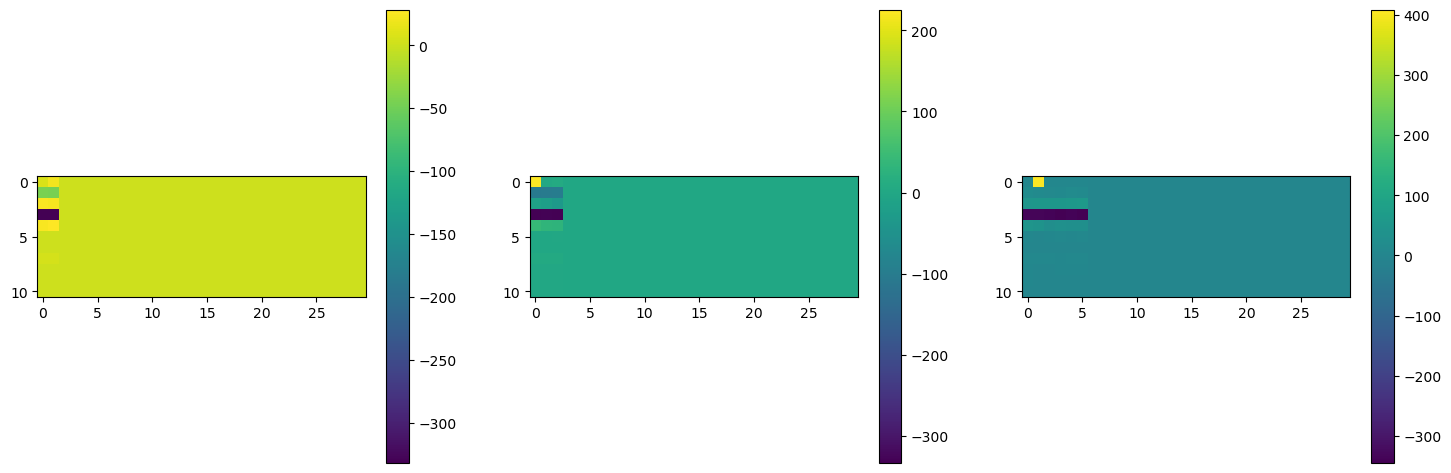

In [121]:
plotM(*x[3:6])

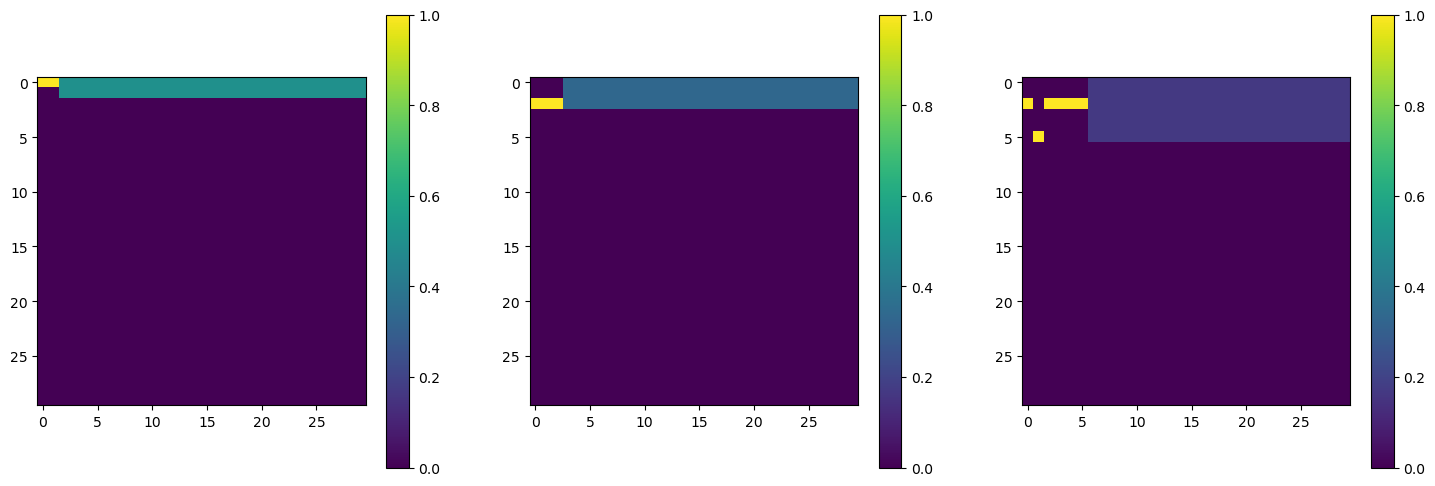

In [126]:
plotM(*att[3:6,2])

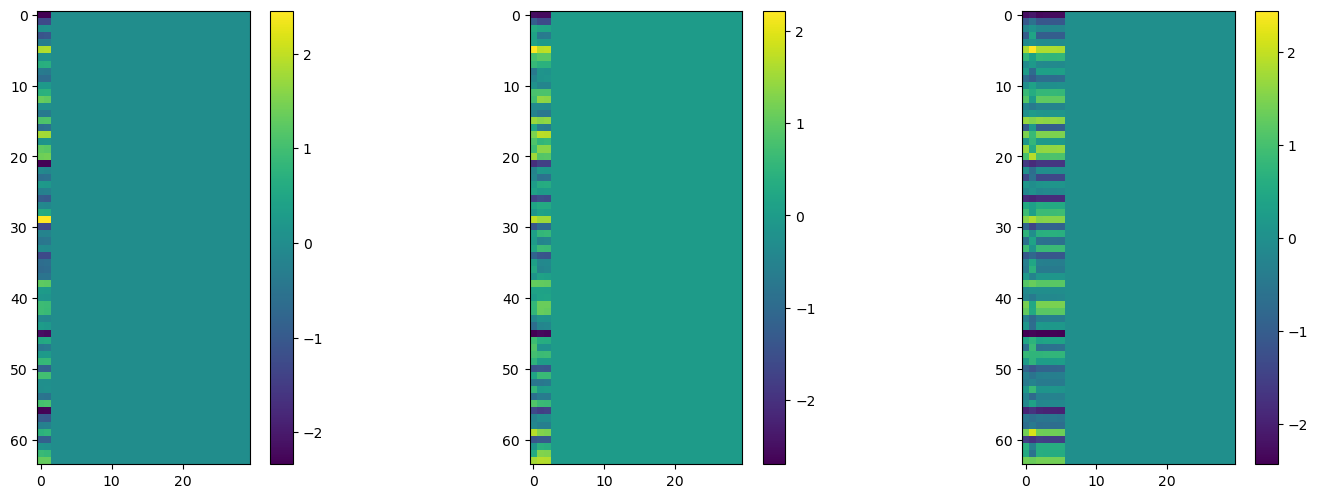

In [127]:
plotM(*out[3:6])

# Training

In [101]:
models_path = "/eos/user/d/dvalsecc/HGCAL_SuperClustering/models/"

from collections import namedtuple
#
Args = namedtuple('args', [ 'name','models_path', 'load','initial_epoch','nepochs','ntrain','nval',
                           'lr_decay','lr', 'batch_size','opt', 'activation', 
                           'output_dim_msa', 'num_heads_msa', 'ff_dim_msa', 'nrepeat_msa',
                          'dropout','l2_reg'])

args = Args( 
models_path = models_path,
name= "test1",
load = False,
initial_epoch = 0,
nepochs = 200,
ntrain = 1000000,
nval = 300000,
lr_decay = 0.,
lr = 1e-3,
batch_size = 64,
opt='adam',
    
activation = tf.keras.activations.selu,
output_dim_msa = 64,
num_heads_msa = 8,
ff_dim_msa = 128,  
nrepeat_msa = 2,
dropout = 0.05,
l2_reg = False
)



In [102]:
import os
def get_unique_run():
    previous_runs = os.listdir(args.models_path)
    if len(previous_runs) == 0:
        run_number = 1
    else:
        run_number = max([int(s.split('run_')[1]) for s in previous_runs]) + 1
    return run_number

if not os.path.isdir(args.models_path):
    os.makedirs(args.models_path)

name =  'run_{:02}'.format(get_unique_run())
outdir = args.models_path + name

if os.path.isdir(outdir):
    print("Output directory exists: {}".format(outdir), file=sys.stderr)
else:
    os.makedirs(outdir)

print(outdir)

/eos/user/d/dvalsecc/HGCAL_SuperClustering/models/run_07


In [103]:
if args.lr_decay > 0:
        #lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        #    args.lr,
        #    decay_steps=int(args.ntrain//args.batch_size),
        #    decay_rate=args.lr_decay
        #)
        lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
            args.lr,
            decay_steps=int(args.ntrain//args.batch_size),
            decay_rate=args.lr_decay,
            staircase=True
        )
else:
    lr_schedule = args.lr



In [105]:
def get_model(args, weights=None):

    tf.keras.backend.clear_session()

    
    with strategy.scope():
        opt = tf.keras.optimizers.Adam(learning_rate=args.lr)
        # Construction of the model
        model = LinkingModel(
                    activation = args.activation,
                    output_dim_msa=args.output_dim_msa,
                    num_heads_msa=args.num_heads_msa,
                    ff_dim_msa=args.ff_dim_msa,
                    nrepeat_msa=args.nrepeat_msa,
                    dropout = args.dropout,
                    l2_reg = args.l2_reg
                    )
        
         
        #     loss_new =  tf.keras.losses.BinaryFocalCrossentropy(
        #         gamma=2.0,
        #         from_logits=False,
        #         label_smoothing=0.0,
        #         axis=-1,
        #         reduction=losses_utils.ReductionV2.AUTO,
        #         name='binary_focal_crossentropy'
        #     )

        model.compile(optimizer=args.opt)
        model.set_metrics()
        
        ypred = model(X[0:args.batch_size])
        if weights:
            model.load_weights(weights)
        return model

In [104]:
callbacks = []
# tb = tf.keras.callbacks.TensorBoard(
#     log_dir=outdir, histogram_freq=2, 
#     write_graph=False, 
#     write_images=True,
#     update_freq='epoch',
#     profile_batch=0,
# )
# tb.set_model(model)
# callbacks += [tb]

terminate_cb = tf.keras.callbacks.TerminateOnNaN()
callbacks += [terminate_cb]

lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, verbose=1,
    mode='auto', min_delta=0.0005, cooldown=0, min_lr=1e-7,
)


cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=outdir + "/weights.{epoch:02d}-{val_loss:.6f}.hdf5",
    save_weights_only=True,
    verbose=1
)
cp_callback.set_model(model)


early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.001, patience=20, verbose=1,
    mode='auto', baseline=None, restore_best_weights=False
)
early.set_model(model)


import plot_loss

loss_plotter = plot_loss.LossPlotter(outdir)
# loss_plotter.set_model(model)


callbacks += [loss_plotter, cp_callback, lr_reduce, early]

In [106]:
model = get_model(args)

In [107]:
model.summary()

Model: "linking_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
MSA_0 (MultiSelfAttentionBlo multiple                  33920     
_________________________________________________________________
MSA_1 (MultiSelfAttentionBlo multiple                  37312     
Total params: 71,234
Trainable params: 71,232
Non-trainable params: 2
_________________________________________________________________


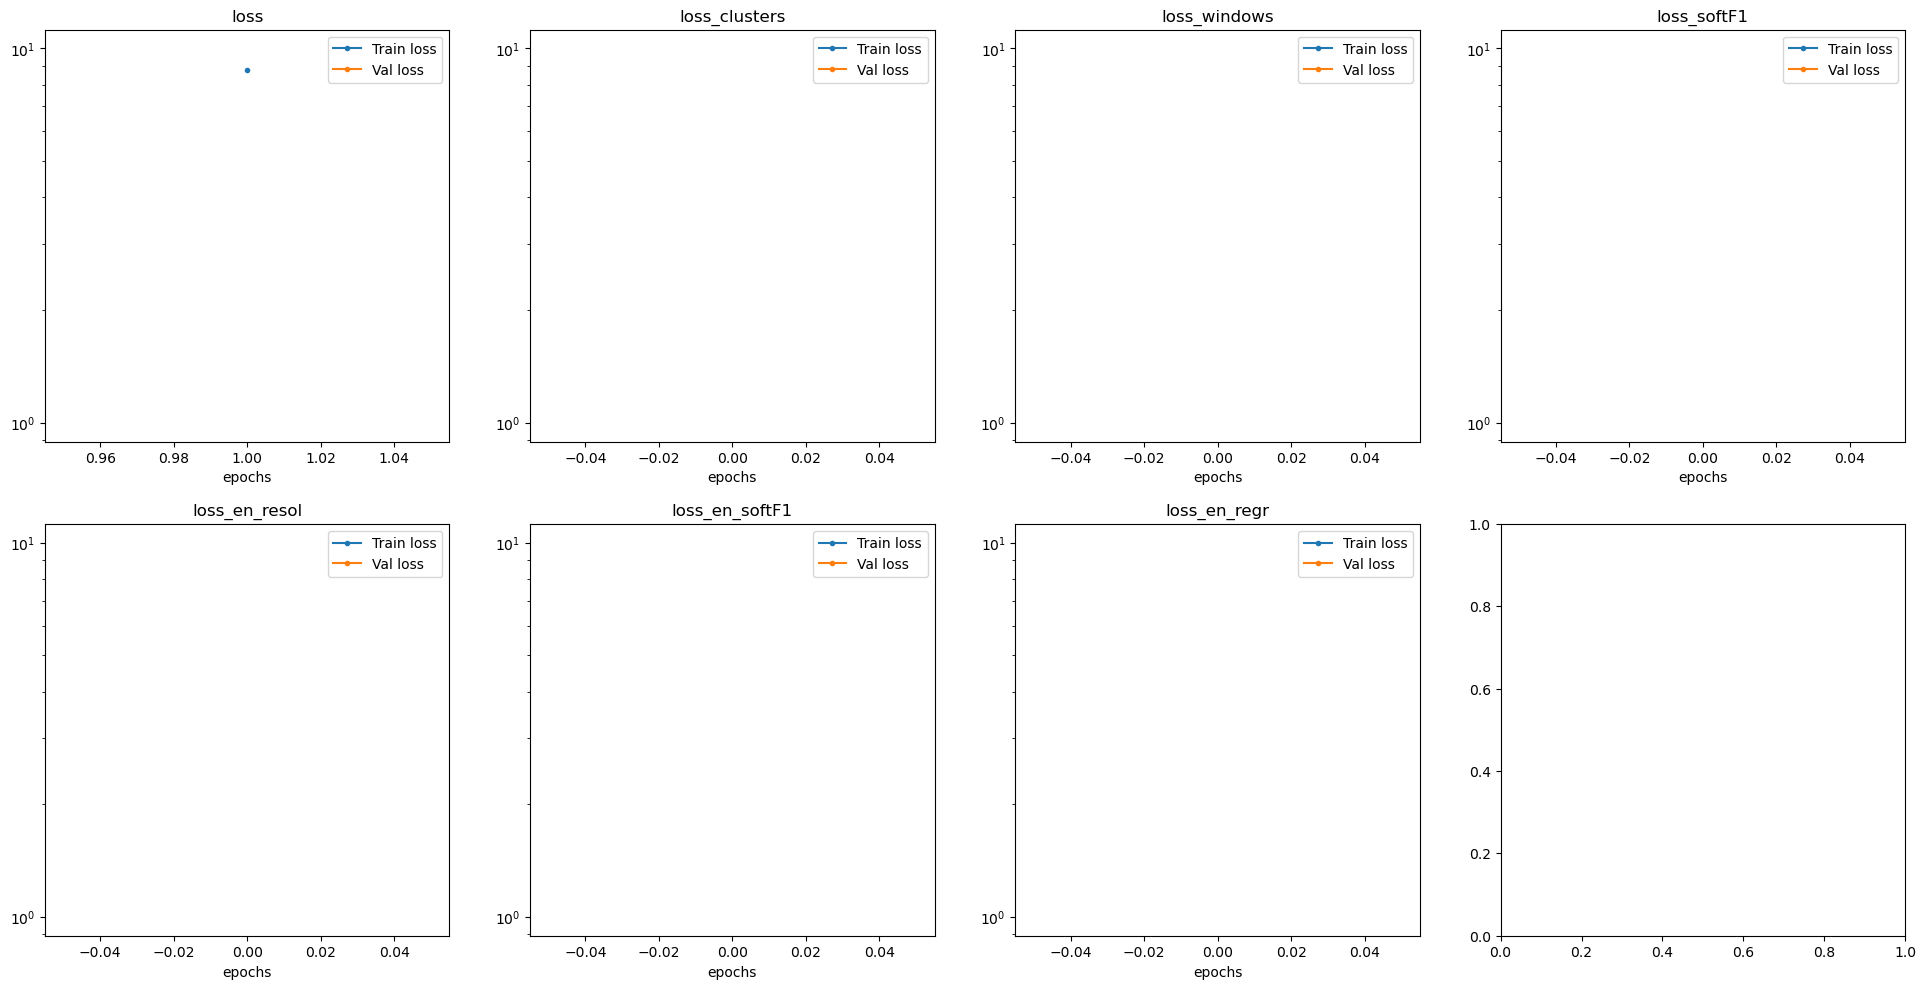

KeyError: 'Failed to format this callback filepath: "/eos/user/d/dvalsecc/HGCAL_SuperClustering/models/run_07/weights.{epoch:02d}-{val_loss:.6f}.hdf5". Reason: \'val_loss\''

In [110]:
if args.nepochs > 0:
    ret = model.fit(
        x=X,
        y=Y,
        batch_size=args.batch_size,
        epochs=args.nepochs,
        verbose=True,
        callbacks = callbacks,
        initial_epoch = args.initial_epoch
    )



In [39]:
model.fit(
    x=X,
    y=Y,
    batch_size=args.batch_size,
    epochs=args.nepochs, 
    verbose='auto',
    callbacks=None,
    validation_split=0.4,
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=args.initial_epoch,
    steps_per_epoch=None,
    validation_steps=None,
    validation_batch_size=None,
    validation_freq=1,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False
)


2022-06-22 16:34:09.514542: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_28740"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = Auto

AttributeError: 'LinkingModel' object has no attribute 'loss_tracker'

In [99]:
reduced_loss

<tf.Tensor: shape=(), dtype=float32, numpy=3.5705843>